In [1]:
import controlSBML as ctl
import random
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
ctl.__version__

'1.0.7'

# Comments

1. Great work. Just a couple of nits.
    1. Please use headings to mark your solutions to the different questions.
    1. Also, your narrative will be more clear if you use separate markdown cells for different questions.

# Question 1

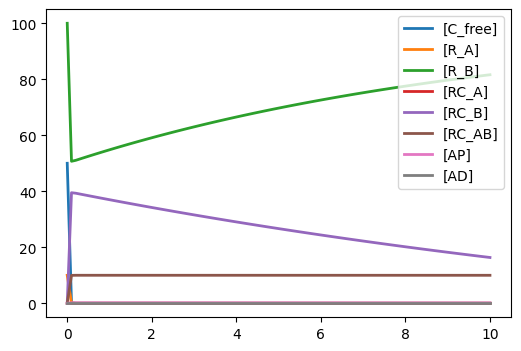

In [2]:
# Question
bsAb_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000788.2?filename=Schropp2019.xml", 
                        input_names=["C_free"], output_names=["RC_B"])
bsAb_RR = bsAb_CTLSB.roadrunner
bsAb_RR.simulate(0, 10, 100)
bsAb_RR.plot()

Question 1b. 
The output I am looking to control is RC_B (the bound protien with receptor B complex, ie the process that will result in a health effect) by controlling the amount of C_free (protien that is not bound to either reseptor). 
Question 1c. 
The main control objectives for this sytem is to reach the setpoint (having the drug response as exact as possible is perferable) and an absense of oscillations is also critical (may make side effects worse, fluctations between being over and undertreated is not perferable). 

# Question 2

In [3]:
bsAb_sys = bsAb_CTLSB.makeNonlinearIOSystem("bsAb_sys")


In [4]:
RC_B_Setpoint= 40

In [5]:
#Create Factory Functions for the PI controller
def makePIController(setpoint=RC_B_Setpoint, kP=1, kI=1):
    """
    Makes a PI controller
    
    Parameters
    ----------
    setpoint: float
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (output from OLS)
        # returns: array-float (derivative of state)
        dx = setpoint - u[0]
        return dx

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        new_err = setpoint - u[0]
        output = kI*x[0] + kP*new_err
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
controller = makePIController()
assert("NonlinearIOSystem" in str(type(controller)))
print("OK")

OK


In [6]:
def makeInterconnect(bsAb_sys=bsAb_sys, **kwargs):
    """
    Create an Interconnect object for the bsAb closed loop system.
    
    Parameters
    ----------
    bsAb_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(**kwargs)
    closed_sys = control.interconnect(
      [bsAb_sys, controller_sys],       # systems
      connections=[
        ['bsAb_sys.C_free', 'controller_sys.out'],
        ['controller_sys.in',  'bsAb_sys.RC_B'],
      ],
      inplist=["controller_sys.in"],
      outlist=["bsAb_sys.RC_B"],
    )
    return closed_sys

# Tests
interconnect = makeInterconnect()
assert("Interconnect" in str(type(interconnect)))
print("OK!")

OK!


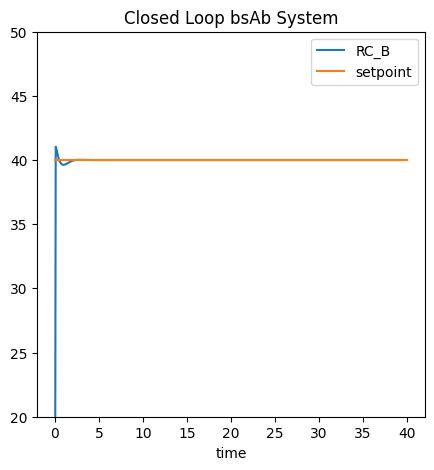

In [7]:
closed_sys = makeInterconnect(kP=3, kI=5)
end_time = 40
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["RC_B"])
ts["setpoint"] = RC_B_Setpoint
# Plot the resultkkk
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[20, 50], title="Closed Loop bsAb System")

# Question 3. 

In [8]:
def flakifier(p=0.8,kf=1):

    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (output from OLS)
        # returns: array-float (derivative of state)
        number=np.random.rand(1)
        if number[0]<=p:
            dx = kf*u[0] - kf*x[0]
        else:
            dx=0
        return dx
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]
    
    return control.NonlinearIOSystem(
          updfcn,
          outfcn,
        states=1,
          inputs=['inf'],
          outputs=['outf'],name='flakifier_sys')

# Tests
flakifier_sys = flakifier()
assert("NonlinearIOSystem" in str(type(flakifier_sys)))
print("OK")
 

OK


In [9]:
def makeInterconnectFlakifier(kP,kI,p,bsAb_sys=bsAb_sys, flakifier_sys=flakifier_sys):
    """
    Create an Interconnect object for the bsAb closed loop system with the Flakifier.
    
    Parameters
    ----------
    bsAb_sys: NonlinearIOSystem
    flakifier_sys:NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(kP,kI)
    flakifier_sys= flakifier(p)
    closed_sys = control.interconnect(
      [bsAb_sys, controller_sys, flakifier_sys],       # systems
      connections=[
        ['flakifier_sys.inf','controller_sys.out'],
        ['controller_sys.in',  'bsAb_sys.RC_B'],['bsAb_sys.C_free','flakifier_sys.outf']
      ],
      inplist=["controller_sys.in"],
      outlist=['bsAb_sys.RC_B'],
    )
    return closed_sys

# Tests
interconnect = makeInterconnectFlakifier(1,1,0)
assert("Interconnect" in str(type(interconnect)))
print("OK!")

OK!


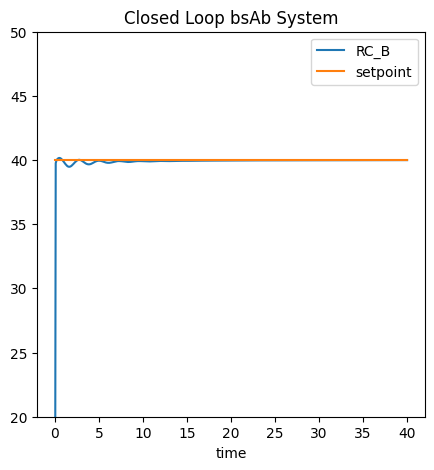

In [10]:
kP=40
kI=10
p=0.8
closed_sys_b = makeInterconnectFlakifier(kP,kI,p)
end_time = 40
ts = ctl.simulateSystem(closed_sys_b, end_time=end_time, output_names=["RC_B"])
ts["setpoint"] = RC_B_Setpoint
# Plot the resultkkk
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[20, 50], title="Closed Loop bsAb System")

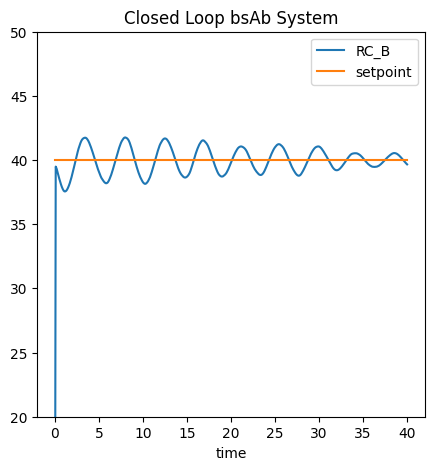

In [11]:
kP=40
kI=10
p=0.2
closed_sys_b = makeInterconnectFlakifier(kP,kI,p)
end_time = 40
ts = ctl.simulateSystem(closed_sys_b, end_time=end_time, output_names=["RC_B"])
ts["setpoint"] = RC_B_Setpoint
# Plot the resultkkk
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[20, 50], title="Closed Loop bsAb System")

# Question 4
Tunning the CLS 1 model was relatively straightforward. Since I wanted to minimize the oscillations, I kept the kI value relatively low and to make sure the response was quick but did not dramatically overshoot, I also kept the kP value in a similar range. The response was relatively quick, so I did not feel like it needed to be faster. Tuning of the CLS2 system was much more difficult. I needed to use much higher values of both kI and kP to maintain the same setpoint. For both p=0.8 and p=0.2, it was impossible to remove the oscillations. For p=0.8, it is possible to decrease the magnitude of the oscillations to a reasonable level and achieve a state close to setpoint, but for the p=0.2 condition is not possible (or extremely difficult) to minimize the oscillations since the signal is being lost so frequently.Too much control results in the system becoming unstable so diminishing oscillation is the best I could get.  